In [5]:
# import relevant modules
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [6]:
# connect to database
CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\alouis2\Documents\Python Scripts\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [7]:
sql1 = pg.SQL('''with missing_dates as (select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = 6 and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f
                EXCEPT
                select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = 5 and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f)

                select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = 5 and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4)) or 

                (intersection_uid = 6 and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4))

                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin; ''')

sql2 = pg.SQL('''with missing_dates as (select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = 20 and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f
                EXCEPT
                select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = 18 and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f)

                select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = 18 and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4)) or 

                (intersection_uid = 20 and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4))

                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin; ''')

sql3 = pg.SQL('''with missing_dates as (select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = 18 and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f
                EXCEPT
                select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = 15 and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f)

                select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = 15 and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4)) or 

                (intersection_uid = 18 and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4))

                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin; ''')


front = pandasql.read_sql(sql1, con)
king1 = pandasql.read_sql(sql2, con)
king2 = pandasql.read_sql(sql3, con)

In [8]:
front5 = pd.DataFrame(front.loc[i,] for i in range(len(front)) if front.loc[i,]['intersection_uid'] == 5)
front6 = pd.DataFrame(front.loc[i,] for i in range(len(front)) if front.loc[i,]['intersection_uid'] == 6)
king15 = pd.DataFrame(king2.loc[i,] for i in range(len(king2)) if king2.loc[i,]['intersection_uid'] == 15)
king182 = pd.DataFrame(king2.loc[i,] for i in range(len(king2)) if king2.loc[i,]['intersection_uid'] == 18)
king181 = pd.DataFrame(king1.loc[i,] for i in range(len(king1)) if king1.loc[i,]['intersection_uid'] == 18)
king20 = pd.DataFrame(king1.loc[i,] for i in range(len(king1)) if king1.loc[i,]['intersection_uid'] == 20)



C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


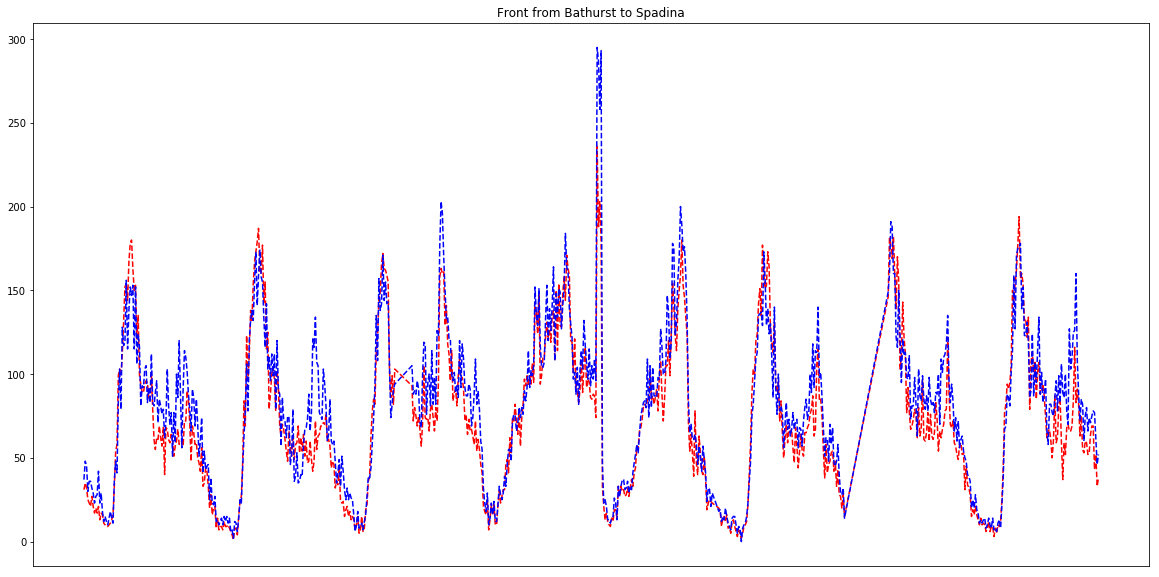

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


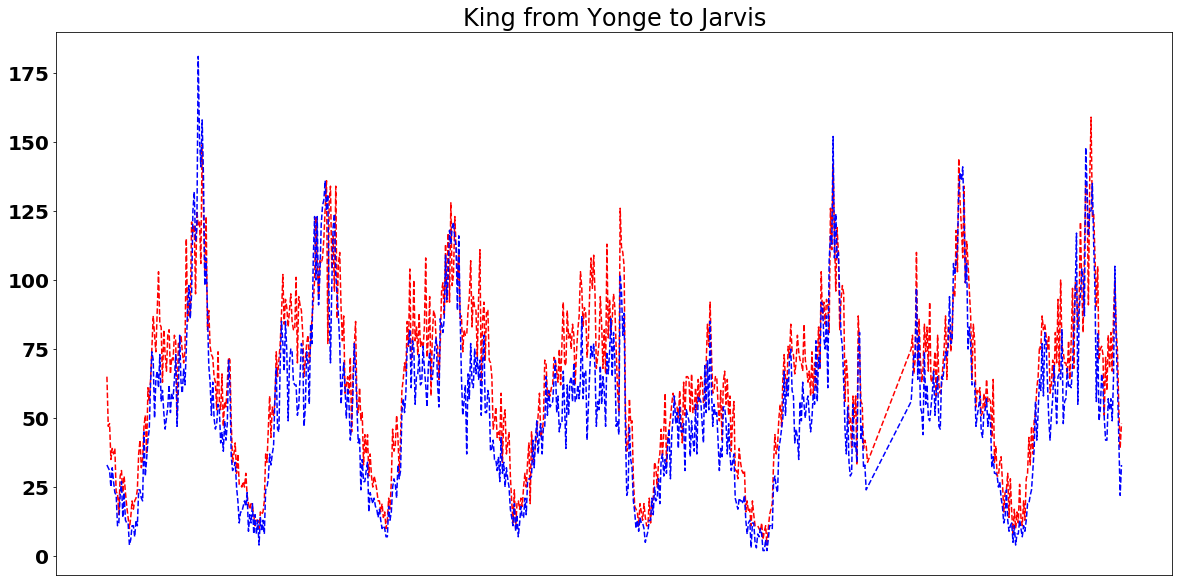

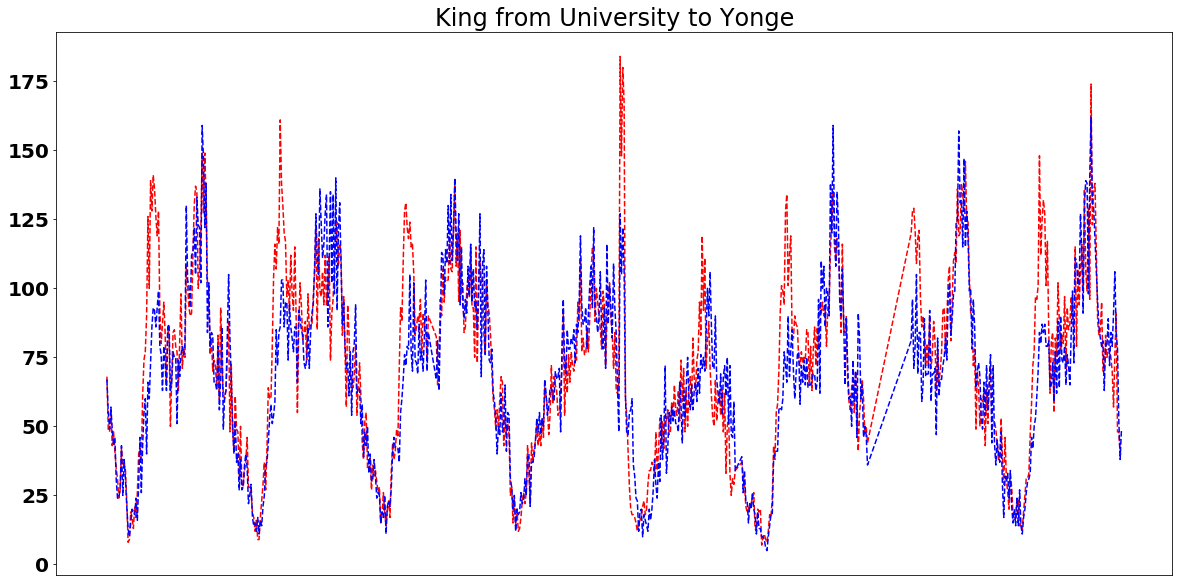

In [9]:
plt.figure(figsize = (20,10))
plt.plot(front5['datetime_bin'], front5['sum'], 'r--', front6['datetime_bin'], front6['sum'], 'b--')
plt.title('Front from Bathurst to Spadina')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])

plt.figure(figsize = (20,10))
plt.plot(king181['datetime_bin'], king181['sum'], 'r--', king20['datetime_bin'], king20['sum'], 'b--')
plt.title('King from Yonge to Jarvis')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])


plt.figure(figsize = (20,10))
plt.plot(king15['datetime_bin'], king15['sum'], 'r--', king182['datetime_bin'], king182['sum'], 'b--')
plt.title('King from University to Yonge')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])


plt.show()

In [111]:
((front6.reset_index(drop = True)['sum'].subtract(front5.reset_index(drop = True)['sum']))**2).sum(),((king20.reset_index(drop = True)['sum'].subtract(king181.reset_index(drop = True)['sum']))**2).sum(), ((king182.reset_index(drop = True)['sum'].subtract(king15.reset_index(drop = True)['sum']))**2).sum()

(244766.0, 191867.0, 241086.25)

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


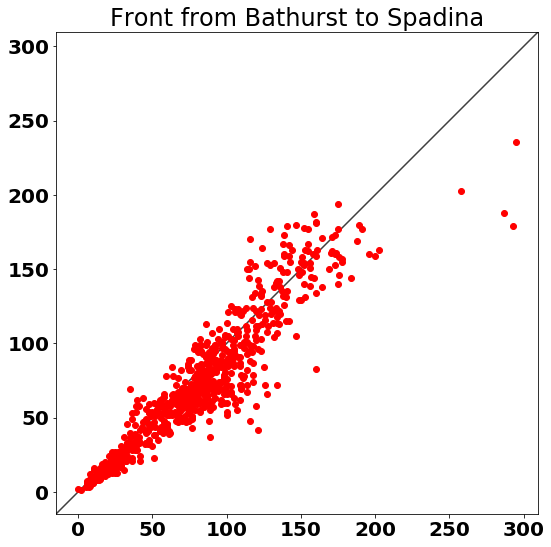

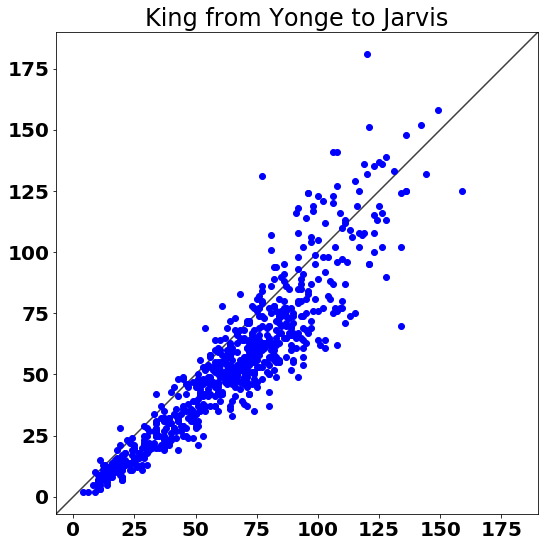

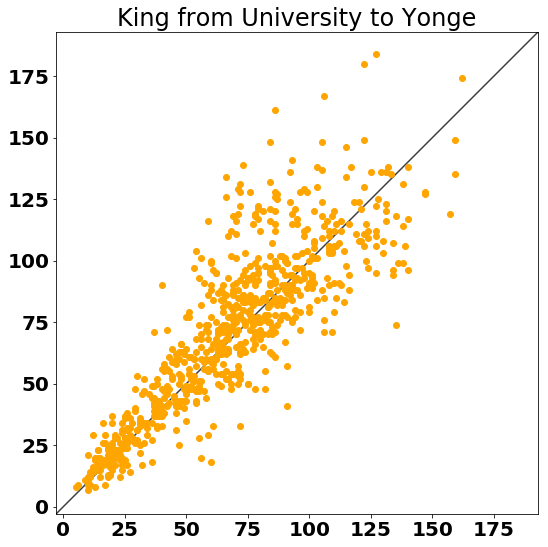

In [128]:
fig, ax = plt.subplots()
ax.scatter(front6.reset_index(drop = True)['sum'], front5.reset_index(drop = True)['sum'], c = 'red')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

plt.title('Front from Bathurst to Spadina')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(8)
fig.set_figwidth(8)
plt.tight_layout()

fig, ax = plt.subplots()
ax.scatter(king181.reset_index(drop = True)['sum'], king20.reset_index(drop = True)['sum'], c = 'blue')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

# now plot both limits against eachother
plt.title('King from Yonge to Jarvis')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(8)
fig.set_figwidth(8)
plt.tight_layout()


fig, ax = plt.subplots()
ax.scatter(king182.reset_index(drop = True)['sum'], king15.reset_index(drop = True)['sum'], c = 'orange')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

plt.title('King from University to Yonge')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(8)
fig.set_figwidth(8)
plt.tight_layout()

plt.show()
